In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices
from jax import pmap, local_devices, local_device_count, process_index, device_get

from tqdm.auto import trange

from models import VAE
from archs import MLP, periodic_encoding
from utils import restore_checkpoint

from configs.default import get_config

import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
%matplotlib inline

print(local_devices())

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
volcano_data = jnp.load('../datasets/volcano.npy')
N, m, _, num_channels = volcano_data.shape

def get_example(u, X, n):
    s = u.reshape(-1,num_channels)
    return u, X, s, jnp.tile(1.0, (X.shape[0],1))

x = jnp.linspace(0,1,m)
y = jnp.linspace(0,1,m)
grid = jnp.meshgrid(x,y)
X = jnp.array(grid).T.reshape(-1,2)

gen_fn = lambda u: get_example(u, X, m)

# Generate training samples
gen_fn = lambda u: get_example(u, X, m)
u_train, y_train, s_train, w_train = vmap(gen_fn)(volcano_data)
print('Training data')
print('u: {}'.format(u_train.shape))
print('y: {}'.format(y_train.shape))
print('s: {}'.format(s_train.shape))
print('w: {}'.format(w_train.shape))

Training data
u: (4096, 128, 128, 2)
y: (4096, 16384, 2)
s: (4096, 16384, 2)
w: (4096, 16384, 1)


In [3]:
# Load trained model
config = get_config()
model = VAE(config)
model = restore_checkpoint(model, 'h512_eps256_beta1e-4_checkpoint_25000')


                             NeuralOperator Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralOperat… │ -             │ float32[1,2] │               │
│               │               │ float32[1,12… │              │               │
│               │               │ -             │              │               │
│               │               │ float32[1,2]  │              │               │
│               │               │ -             │              │               │
│               │               │ float32[256]  │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder       │ ConvEncoder   │ -             │ -            │               │
│               │          

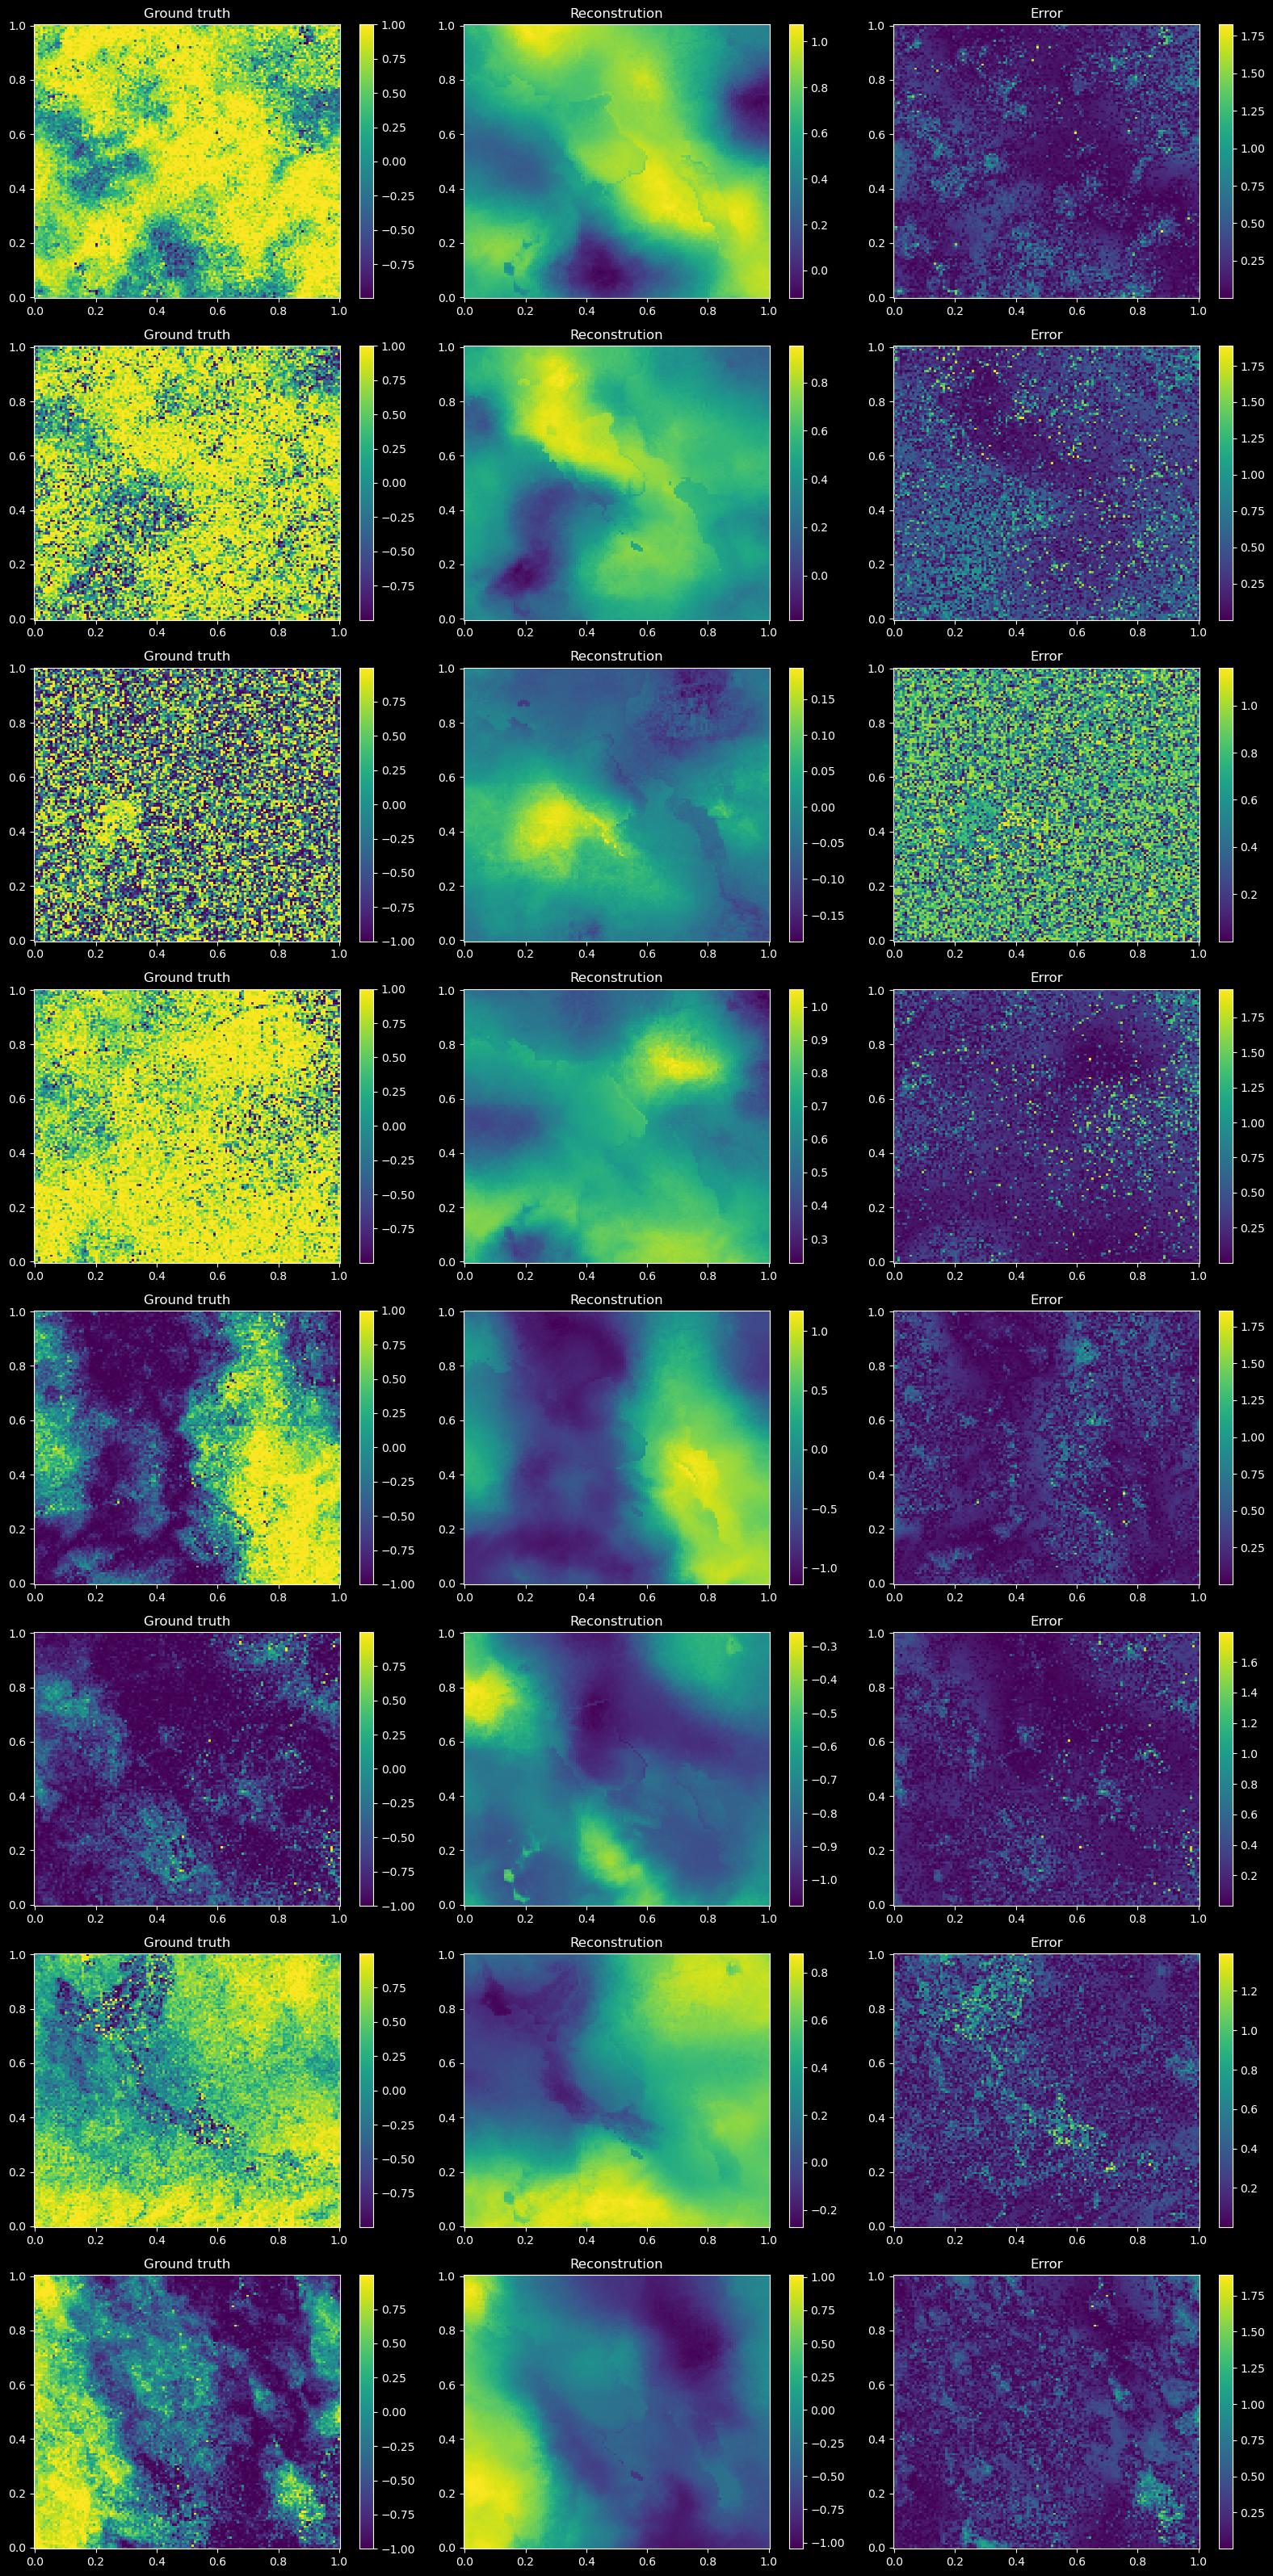

In [7]:
# Train reconstructions
num_samples = 8
key = random.PRNGKey(0)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_train = random.normal(key, (u_train.shape[0], config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_train[idx,...], y_train[idx,...], eps_train[idx,...])
s_pred = pmap(pred_fn)(model.state.params)[0,...]

# error_fn = lambda target, output: jnp.linalg.norm(target-output,2)/jnp.linalg.norm(target,2)
# error = vmap(error_fn, in_axes=(0,0))(s_test, s_pred)
# print('Relative L2 error: {:.2e}'.format(jnp.mean(error)))

plt.figure(figsize=(16, num_samples*4))
cnt=0
for i in range(num_samples):
    # Grounf truth
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_train[idx[i],...,-1].reshape(m,m), shading='auto')
    plt.colorbar()
    plt.title('Ground truth')
    # Prediction
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_pred[i,...,-1].reshape(m,m), shading='auto')
    plt.colorbar()
    plt.title('Reconstrution')
    # Error
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    error = jnp.abs(s_train[idx[i],...,-1] - s_pred[i,...,-1])
    plt.pcolor(grid[0], grid[1], error.reshape(m,m), shading='auto')
    plt.colorbar()
    plt.title('Error')
plt.tight_layout()
plt.savefig('reconstructions.png', dpi=300)
plt.show()

In [11]:
# Generate samples
batch_size = 32
num_devices = local_device_count()
num_steps = N // (batch_size*num_devices)
sample_fn = lambda params, eps: model.state.decode_fn(params, eps, y_train[:batch_size,...])

samples = []
for i in trange(num_steps):
    key = random.PRNGKey(i)
    eps_test = random.normal(key, (num_devices, batch_size, config.eps_dim))
    samples.append(pmap(sample_fn, in_axes=(0,0))(model.state.params, eps_test))
    
samples = jnp.array(samples).reshape(N,m,m,num_channels)
print(samples.shape)

  0%|          | 0/128 [00:00<?, ?it/s]

(4096, 128, 128, 2)


In [12]:
def circular_var(x, dim=None):
    #R = torch.sqrt((x.mean(dim=(1,2))**2).sum(dim=1))
    phase = jnp.arctan2(x[:,:,:,1], x[:,:,:,0])
    phase = (phase + jnp.pi) % (2 * jnp.pi) - jnp.pi
    
    C1 = jnp.cos(phase).sum(axis=(1,2))
    S1 = jnp.sin(phase).sum(axis=(1,2))
    R1 = jnp.sqrt(C1**2 + S1**2) / (phase.shape[1]*phase.shape[2])
    return 1 - R1

def circular_skew(x):
    phase = jnp.arctan2(x[:,:,:,1], x[:,:,:,0])
    phase = (phase + jnp.pi) % (2 * jnp.pi) - jnp.pi
    
    C1 = jnp.cos(phase).sum(axis=(1,2))
    S1 = jnp.sin(phase).sum(axis=(1,2))
    R1 = jnp.sqrt(C1**2 + S1**2) / (phase.shape[1]*phase.shape[2])
    
    C2 = jnp.cos(2*phase).sum(axis=(1,2))
    S2 = jnp.sin(2*phase).sum(axis=(1,2))
    R2 = jnp.sqrt(C2**2 + S2**2) / (phase.shape[1]*phase.shape[2])
    
    T1 = jnp.arctan2(S1, C1)
    T2 = jnp.arctan2(S2, C2)

    return R2 * jnp.sin(T2 - 2*T1) / (1 - R1)**(3/2)

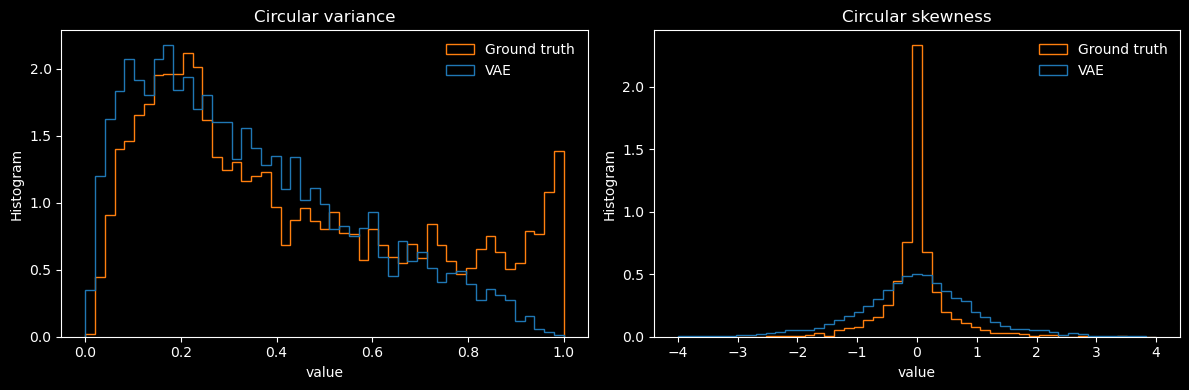

In [13]:
# Compute metrics
var_true = circular_var(volcano_data)
skew_true = circular_skew(volcano_data)

var_gen = circular_var(samples)
skew_gen = circular_skew(samples)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(var_true, bins=jnp.linspace(0.0, 1.0, 50), histtype='step', density=True, color='#ff7f0e', label='Ground truth')
plt.hist(var_gen, bins=jnp.linspace(0.0, 1.0, 50), color='#1f77b4' , histtype='step', density=True, label='VAE')
plt.legend(frameon=False)
plt.xlabel('value')
plt.title('Circular variance')
plt.ylabel('Histogram')
plt.subplot(1,2,2)
plt.hist(skew_true, bins=jnp.linspace(-4.0, 4.0, 50), histtype='step', density=True, color='#ff7f0e', label='Ground truth')
plt.hist(skew_gen, bins=jnp.linspace(-4.0, 4.0, 50), color='#1f77b4' , histtype='step', density=True, label='VAE')
plt.legend(frameon=False)
plt.xlabel('value')
plt.title('Circular skewness')
plt.ylabel('Histogram')
plt.tight_layout()
plt.savefig('volcano_statistics.png', dpi=300)
plt.show()


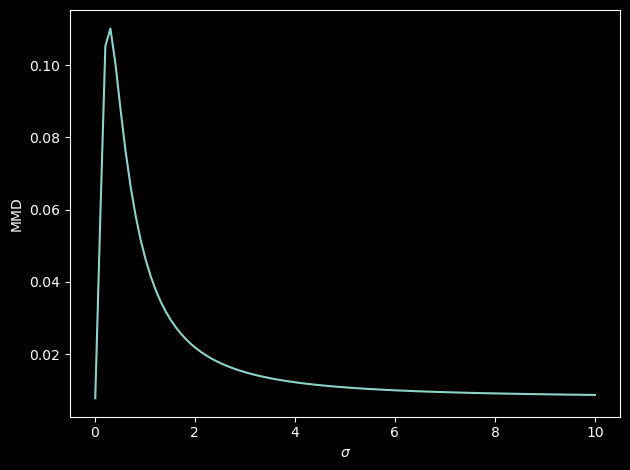

: 

In [17]:
def compute_mmd(config, model, num_samples=256):
    # Generate samples from model
    key = random.PRNGKey(123)
    eps_test = random.normal(key, (num_samples, config.eps_dim))
    sample_fn = lambda params: model.state.decode_fn(params, eps_test, y_train[:num_samples,...])
    samples = pmap(sample_fn)(model.state.params)[0,...]

    def MMD(X, Y, k):
        n = X.shape[0]
        m = Y.shape[0]
        kXX = k(X,X)
        kYY = k(Y,Y)
        kXY = k(X,Y)
        Xterm = 1./(n*(n-1))*jnp.sum(kXX)
        Yterm = 1./(m*(m-1))*jnp.sum(kYY)
        XYterm = 1./(n*m)*jnp.sum(kXY)
        return Xterm + Yterm - 2*XYterm

    dim = samples.shape[1]
    kernelfunc = lambda x, y, sigmasq: jnp.exp(- 1./(2*sigmasq*dim) * jnp.dot(x-y, x-y))

    # Define sweep range and containers
    sigmasqs = jnp.linspace(1e-2,10,100)
    def get_mmds(X, Y, sigmasq):
        kernel = lambda x, y: kernelfunc(x, y, sigmasq)
        k = vmap(vmap(kernel, in_axes=(None, 0)), in_axes=(0, None))
        mmd = MMD(X, Y, k)
        return mmd

    mmds = vmap(get_mmds, in_axes=(None,None,0))(samples.reshape(num_samples,-1), 
                                                 s_train[:num_samples,...].reshape(num_samples,-1),
                                                 sigmasqs)
    return mmds
    
mmds = compute_mmd(config, model)

plt.figure()
plt.plot(jnp.linspace(1e-2,10,100), mmds)
plt.xlabel(r'$\sigma$')
plt.ylabel('MMD')
plt.tight_layout()
plt.show()